```
Date: 4/10/2022
Author: Arup Sarker
Author Email: djy8hg@virginia.edu
```
## Install dependencies

In [ ]:
pip install pybind11


     |████████████████████████████████| 213 kB 7.3 MB/s 


In [ ]:
pip install git+https://github.com/Koukyosyumei/AIJack

  Cloning https://github.com/Koukyosyumei/AIJack to /tmp/pip-req-build-4xdnmghq
  Running command git clone -q https://github.com/Koukyosyumei/AIJack /tmp/pip-req-build-4xdnmghq
  Created wheel for aijack: filename=aijack-0.0.0-cp37-cp37m-linux_x86_64.whl size=129104 sha256=c8c7229e58f24fe829c5047a910354c4424db2686b8420c84136113871828291
  Stored in directory: /tmp/pip-ephem-wheel-cache-2qmw19o1/wheels/3b/84/9e/451bfe20785b1a7b8f8b1701a945a2bcafd4ba3d4b0c7f10ce
Successfully built aijack


## Data Poisoning Attacks


In [ ]:
import os
import time
import copy
import random
from tqdm import tqdm

import numpy as np

import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from aijack.attack import Poison_attack_sklearn

In [ ]:
mnist = datasets.fetch_openml("mnist_784", version=1, data_home=".", return_X_y=True)
imagedata, labeldata = mnist[0].values, mnist[1].values

index_3 = [i for i, x in enumerate(labeldata) if x == "3"]
index_7 = [i for i, x in enumerate(labeldata) if x == "7"]
image_data_3_7 = imagedata[index_3 + index_7]
label_data_3_7 = labeldata[index_3 + index_7]

(
    imagedata_training,
    imagedata_validation,
    labeldata_training,
    labeldata_validation,
) = train_test_split(image_data_3_7, label_data_3_7, test_size=0.2, shuffle=True)

imagedata_training = imagedata_training / 255.0
imagedata_validation = imagedata_validation / 255.0

X_train = imagedata_training[:5000]
y_train = labeldata_training[:5000]
X_valid = imagedata_validation[:500]
y_valid = labeldata_validation[:500]

# X_train = np.load("data/X_train.npy", allow_pickle=True)
# y_train = np.load("data/y_train.npy", allow_pickle=True)
# X_valid = np.load("data/X_valid.npy", allow_pickle=True)
# y_valid = np.load("data/y_valid.npy", allow_pickle=True)

In [ ]:
 #Train Target Model before attacks
start = time.time()
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)
elapsed_time = time.time() - start
print("Arup: check accuracy before attack")
print("elapsed_time training:{0}".format(elapsed_time) + "[sec]")

start = time.time()
predict = clf.predict(X_valid)
elapsed_time = time.time() - start
print("elapsed_time predict:{0}".format(elapsed_time) + "[sec]")

ac_score = metrics.accuracy_score(y_valid, predict)
cl_report = metrics.classification_report(y_valid, predict)
print("Accuracy score = ", ac_score)
print(cl_report)

Arup: check accuracy before attack
elapsed_time training:1.2963523864746094[sec]
elapsed_time predict:0.03140068054199219[sec]
Accuracy score =  0.986
              precision    recall  f1-score   support

           3       0.99      0.98      0.99       235
           7       0.98      0.99      0.99       265

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



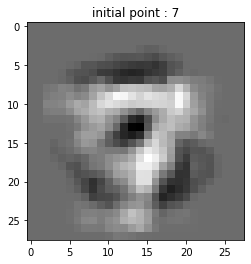

In [ ]:
# initial point
initial_idx = 0
xc = X_train[initial_idx, :]
yc = y_train[initial_idx]

plt.imshow(xc.reshape(28, 28), cmap="gray")
plt.title(f"initial point : {yc}")
plt.savefig("original_seven.png")
plt.show()

In [ ]:
train_idx = random.sample(list(range(1, X_train.shape[0])), 100)
X_train_ = copy.copy(X_train[train_idx, :])
y_train_ = copy.copy(y_train[train_idx])

y_train_ = np.where(y_train_ == "7", 1, -1)
y_valid_ = np.where(y_valid == "7", 1, -1)

In [ ]:
attacker = Poison_attack_sklearn(clf, X_train_, y_train_, t=0.5)

xc_attacked, log = attacker.attack(xc, 1, X_valid, y_valid_, num_iterations=200)

100%|██████████| 200/200 [00:06<00:00, 33.00it/s]


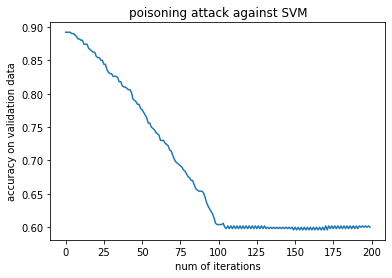

In [ ]:
plt.plot(log)
plt.title("poisoning attack against SVM")
plt.xlabel("num of iterations")
plt.ylabel("accuracy on validation data")
plt.savefig("poison_loss.png")
plt.show()

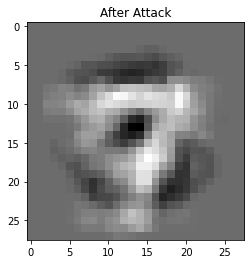

In [ ]:
plt.imshow(xc_attacked.reshape(28, 28), cmap="gray")
plt.title("After Attack")
plt.savefig("poison_example.png")
plt.show()

In [ ]:
clf = SVC(kernel="linear", C=1)
clf.fit(X_train_, y_train_)
print("before attack: ", clf.score(X_valid, y_valid_))

# add poinsoned data
clf = SVC(kernel="linear", C=1)
clf.fit(
    np.concatenate([X_train_, xc_attacked.reshape(1, -1)]),
    np.concatenate([y_train_, [-1]]),
)
print("after attack: ", clf.score(X_valid, y_valid_))

before attack:  0.96
after attack:  0.842
